In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import warnings

warnings.filterwarnings('ignore')

In [5]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from model_utils import train_torch_model, test_torch_model, port_mlp_to_ch, port_ch_to_mlp, proxy_train_mlp, get_CSMIA_case_by_case_results, CSMIA_attack
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from whitebox_attack import neuron_output, make_neuron_output_data, roc_curve_plot, get_LOMIA_case_1_correct_examples, Top10CorrNeurons, wb_corr_attacks
from disparate_vulnerability_utils import get_accuracy, get_indices_by_conditions, subgroup_vulnerability_distance_vector, subgroup_vulnerability_distance, get_subgroup_disparity, plot_subgroup_disparity, improved_subgroup_attack, get_subgroup_disparity_baseline, get_top_dist_indices, get_disparity_by_subgroup
import shap
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [6]:
class MIAExperiment:
    def __init__(self, *args, **kwargs):
        self.sampling_condition_dict_list = kwargs.get('sampling_condition_dict_list', None)
        self.sensitive_column = kwargs.get('sensitive_column', 'MAR')

        for key, value in kwargs.items():
            setattr(self, key, value)

        if not hasattr(self, 'name'):
            self.name = 'Census19'
        self.ds = data_utils.CensusWrapper(
                    filter_prop="none", ratio=float(0.5), split="all", name=self.name, sampling_condition_dict_list=self.sampling_condition_dict_list, sensitive_column=self.sensitive_column,
                    additional_meta=None)
        (self.x_tr, self.y_tr), (self.x_te, self.y_te), self.cols = self.ds.load_data()
        self.X_train = pd.DataFrame(self.x_tr, columns=self.cols)
        self.X_test = pd.DataFrame(self.x_te, columns=self.cols)
        self.y_tr_onehot = self.ds.ds.y_enc.transform(self.y_tr).toarray()
        self.y_te_onehot = self.ds.ds.y_enc.transform(self.y_te).toarray()

    def __str__(self):
        return self.ds.ds.filenameroot
    
    def __repr__(self):
        return self.ds.ds.filenameroot
    
    def get_value_count_report(self):
        df = self.ds.ds.original_df
        df = df[df['is_train'] == 1]
        subgroup_values = df[self.subgroup_column].unique().tolist()
        for value in subgroup_values:
            print(f"Subgroup: {value}")
            # print(df[df[self.subgroup_column] == value].columns)
            # print(df[df[self.subgroup_column] == value][[self.sensitive_column, self.y_column]])
            new_df = df[df[self.subgroup_column] == value][[self.sensitive_column, self.y_column]]
            print(new_df.value_counts())
            # print(df[df[self.subgroup_column == value]][[self.sensitive_column, self.y_column]].corr())


    def get_mutual_information_between_sens_and_y(self):
        df = self.ds.ds.original_df
        df = df[df['is_train'] == 1]
        subgroup_values = df[self.subgroup_column].unique().tolist()
        mutual_info_dict = {}
        for value in subgroup_values:
            print(f"Subgroup: {value}")
            # All the features except y column
            X = df[df[self.subgroup_column] == value].drop([self.y_column], axis=1)
            y = df[df[self.subgroup_column] == value][[self.y_column]]
            # print(mutual_info_classif(X, y, discrete_features=True))
            mutual_info_dict[value] = mutual_info_classif(X, y, discrete_features=True)
        return mutual_info_dict

In [7]:
experiments = { f"corr_btn_sens_and_out_{(i, j)}":  MIAExperiment(sampling_condition_dict_list = 
    {
            'correlation': 0,
            'subgroup_col_name': 'SEX',
            'marginal_prior': 1,
            'corr_btn_sens_and_output_per_subgroup': (i, j),
            # 'fixed_corr_in_test_data': True
    }, shortname = f"Corr_btn_sens_and_output_for_male_({i})_for_female_({j})"
) for (i, j) in [(k, k) for k in [-0.4, -0.35, -0.3, -0.25, -0.2][:1]]}
# ) for i in [-0.4, -0.3, -0.2, -0.1, 0][:1] for j in [-0.4, -0.3, -0.2, -0.1, 0][3:4]}

{0: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}, 1: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}}


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


In [8]:
save_model = False

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf_only_on_train = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_train_dummyy_2.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        base_model = model_utils.get_model(max_iter=500)
        experiment.clf_only_on_train = copy.deepcopy(base_model)
        experiment.clf_only_on_train.fit(experiment.X_train, experiment.y_tr_onehot)

        # if save_model:
        #     model_utils.save_model(experiment.clf_only_on_train, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_train_dummy.pkl')

Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.4, -0.4RPAREN


In [9]:
save_model = False

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf_only_on_test = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummyy_2.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        base_model = model_utils.get_model(max_iter=500)
        experiment.clf_only_on_test = copy.deepcopy(base_model)
        experiment.clf_only_on_test.fit(experiment.X_test, experiment.y_te_onehot)

        if save_model:
            model_utils.save_model(experiment.clf_only_on_test, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummy.pkl')

Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.4, -0.4RPAREN


In [10]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(experiment.shortname)
    print(get_CSMIA_case_by_case_results(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric='accuracy'))

Corr_btn_sens_and_output_for_male_(-0.4)_for_female_(-0.4)
                              1                0  Overall
Case 1           4528 (70.0309)   4312 (69.2022)  69.6267
Case 2          17836 (68.2048)  17694 (68.8312)  68.5167
Case 3           2636 (63.7709)    2994 (58.016)  60.7105
Case All Cases   25000 (68.068)     25000 (67.6)  67.8340


In [11]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(experiment.shortname)
    print(get_CSMIA_case_by_case_results(experiment.clf_only_on_train, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric='accuracy'))

Corr_btn_sens_and_output_for_male_(-0.4)_for_female_(-0.4)
                             1                0  Overall
Case 1          2642 (57.6457)   2791 (43.7478)  50.5062
Case 2          18305 (59.776)  17697 (45.1998)  52.6110
Case 3          4053 (53.3679)   4512 (48.1161)  50.6013
Case All Cases  25000 (58.512)   25000 (45.564)  52.0380


In [14]:
def whitebox_neuron_attack(experiment, clf, subgroup_column='SEX'):
    original_df_onehot = experiment.ds.ds.df.copy()

    original_df_onehot = original_df_onehot[original_df_onehot["is_train"]==0].drop("is_train", axis=1)

    X_attack_orig, y_sens_orig = experiment.ds.ds.get_attack_df(original_df_onehot)
    X_attack_orig = X_attack_orig.astype(float)

    x_tr, x_te, y_tr, y_te = train_test_split(X_attack_orig, y_sens_orig, test_size=0.9, random_state=42)
    x_n_tr = make_neuron_output_data(experiment.ds, x_tr, clf, experiment.ds.ds.y_columns)
    x_n_te = make_neuron_output_data(experiment.ds, x_te, clf, experiment.ds.ds.y_columns)

    top_10_corr_neurons_model = wb_corr_attacks(x_n_tr, y_tr)

    y_preds = top_10_corr_neurons_model(torch.from_numpy(X_attack_orig.to_numpy()).float()).detach().numpy()
    y_preds = np.where(y_preds > top_10_corr_neurons_model.threshold, 1, 0)

    # result_dict = get_disparity_by_subgroup(attack_type='NEUR_IMP', ds=experiment.ds, subgroup_columns=[subgroup_column], X_att_query=X_attack_orig, y_att_query=y_sens_orig, metric='accuracy', clf=top_10_corr_neurons_model, df=X_attack_orig, MLP=clf)
    return y_preds

In [21]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(experiment.shortname)
    print(whitebox_neuron_attack(experiment, experiment.clf_only_on_test))

Corr_btn_sens_and_output_for_male_(-0.4)_for_female_(-0.4)
{'SEX': {0: 64.1, 1: 62.936, 'original': 63.517999999999994}}


In [22]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(experiment.shortname)
    print(whitebox_neuron_attack(experiment, experiment.clf_only_on_train))

Corr_btn_sens_and_output_for_male_(-0.4)_for_female_(-0.4)
{'SEX': {0: 65.68, 1: 62.124, 'original': 63.902}}


In [12]:
experiments.keys()

dict_keys(['corr_btn_sens_and_out_(-0.4, -0.4)'])

In [20]:
experiment = experiments['corr_btn_sens_and_out_(-0.4, -0.4)']
CSMIA_results = [get_CSMIA_case_by_case_results(clf, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric='accuracy').loc['Case All Cases'][['Overall']].to_numpy()[0] for clf in [experiment.clf_only_on_test, experiment.clf_only_on_train]]

whitebox_results = [whitebox_neuron_attack(experiment, clf)['SEX']['original'] for clf in [experiment.clf_only_on_test, experiment.clf_only_on_train]]

In [21]:
CSMIA_results

[67.832, 52.042]

In [22]:
whitebox_results

[63.517999999999994, 63.902]

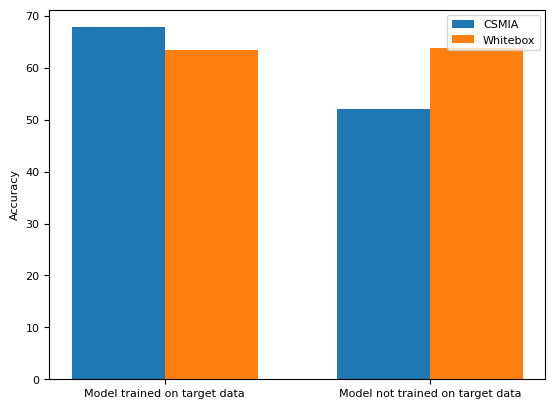

In [23]:
labels = ['Model trained on target data', 'Model not trained on target data']
width = 0.35  # the width of the bars

# Plotting
fig, ax = plt.subplots()
x = np.arange(len(labels))  # the label locations
rects1 = ax.bar(x - width/2, CSMIA_results, width, label='CSMIA')
rects2 = ax.bar(x + width/2, whitebox_results, width, label='Whitebox')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
# ax.set_title('Scores by experiment and method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()